# **Nonlinear Optimization 2024.2**

### **Optimum power for a set of $m$ lamps iluminating a set of $n$ flat patches to best approach a target illumination**

Consider $m$ lamps illuminating $n$ (small flat) patches. The illumination intensity $I_k$ at the $k$-th patch depends linearly on the lamp power $p_j$ as:

\begin{equation*}
    I_k = \displaystyle \sum_{j=1}^{m}a_{k,j}p_j, \quad \text{with} a_{k,j} = r_{k,j}^{-2}\max\{cos(\theta_{k.,j},0)\},
\end{equation*}

where $r_{k,j}$ is the length of the vector $r_{k,j}$ connecting the center of the $k$-th patch to the position of the $m$-th lamp and $\theta_{k,j}$ is the angle between the patch normal vector $\mathbf{n}_k$ and $\mathbf{r}_{k,j}$. See the Convex Optimization book slides for more details.

The proposed problem is to achieve a desired illumination $I_{des}$ with bounded lamp powers ($p_{max}$), i.e.,

\begin{align*}
    & \min \underset{k=1,2,\dots,n}{\max}\vert \log{(I_k)} - \log{(I_{des})} \vert \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \dots, m.
\end{align*}

#### **Suboptimally solve the problem using, e.g., Python or Octave, according to the following approaches:**

1. Using uniform power, i.e., $p_j = p, 0 \leq p \leq p_{max}$.
2. Using least-squares, i.e., $\min . \displaystyle \sum_{k-1}^{n} (I_k - I_{des})^2$, and rounding $p_j$ as $p_j = \max\{0, \min{p_j, p_{max}}\}$.
3. Using weighted least-squares, i.e., $\min . \displaystyle \sum_{k=1}^{n}(I_k - I_{des})^2 + \sum_{j=1}^n (p_j - p_{max})^2$ and iteratively adjusting the weights $w_j$ until $0 \leq p \leq p_{max}, \forall j$.
4. Using linear programming, i.e., 

\begin{align*}
    & \min . \underset{k=1, 2, \dots, n}{\max} \vert I_{k} - I_{des} \vert \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \dots, m.
\end{align*}

#### **Solve the problem optimally using convex optimization**

For this goal, consider the equivalent convex problem

\begin{align*}
    & \min . \underset{k = 1, 2, \dots, n}{\max} h\left(\cfrac{I_k}{I_{des}}\right) \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \dots, m, 
\end{align*}

where $h(u) = \max\left\{u, \cfrac{1}{u}\right\}$

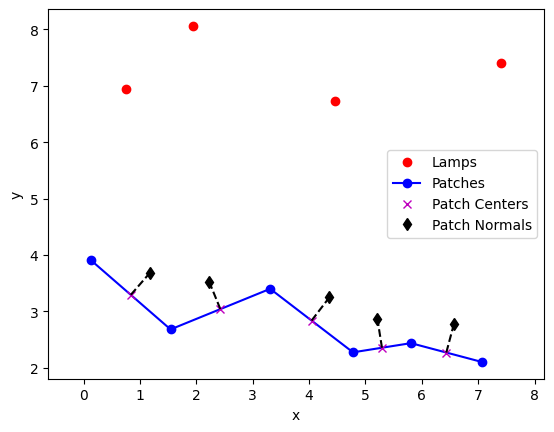

In [1]:
import numpy as np
import matplotlib.pyplot as plt

showFig = True
numLamps = 4            # number of lamps
numPatches = 5          # number of patches
maxPwr = 1              # maximum power
desiredillum = 0.01     # desired illumination

# Define lamp and patch positions
lampPos = np.array([
    [0.7609, 6.9497],
    [1.9382, 8.0610],
    [4.4674, 6.7316],
    [7.4095, 7.3987]
])

patchPos = np.array([
    [0.1329, 3.9041],
    [1.5435, 2.6782],
    [3.3102, 3.3981],
    [4.7796, 2.2716],
    [5.8071, 2.4345],
    [7.0621, 2.1015]
])

lampPos = lampPos[:, 0] + 1j * lampPos[:, 1]
patchPos = patchPos[:, 0] + 1j * patchPos[:, 1]
patchCenter = (patchPos[:-1] + patchPos[1:]) / 2
patchNorm = patchPos[1:] - patchPos[:-1]
minPatchLength = np.min(np.abs(patchNorm)) / 2

for p in range(len(patchNorm)):
    n = np.linalg.svd(np.array([[np.real(patchNorm[p]), np.imag(patchNorm[p])]]).T)[0][:, 1]
    patchNorm[p] = minPatchLength * (n[0] + 1j * n[1])

if showFig:
    plt.plot(np.real(lampPos), np.imag(lampPos), 'ro', markerfacecolor='auto', label='Lamps')
    plt.plot(np.real(patchPos), np.imag(patchPos), 'bo-', markerfacecolor='auto', label='Patches')
    plt.plot(np.real(patchCenter), np.imag(patchCenter), 'mx', markerfacecolor='auto', label='Patch Centers')
    plt.plot(np.real(patchNorm + patchCenter), np.imag(patchNorm + patchCenter), 'kd', markerfacecolor='auto', label='Patch Normals')
    
    for i in range(len(patchCenter)):
        plt.plot([np.real(patchCenter[i]), np.real(patchNorm[i] + patchCenter[i])],
                 [np.imag(patchCenter[i]), np.imag(patchNorm[i] + patchCenter[i])], 'k--')
    
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

radDist = np.zeros((len(patchCenter), len(lampPos)))
angShift = np.zeros((len(patchCenter), len(lampPos)))

for i in range(len(patchCenter)):
    for j in range(len(lampPos)):
        radDist[i, j] = np.abs(patchCenter[i] - lampPos[j])
        angShift[i, j] = np.angle(lampPos[j] - patchCenter[i]) - np.angle(patchNorm[i])

illumCoeff = radDist ** (-2) * np.maximum(np.cos(angShift), 0)
